---
#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---
#### Load Data

* The dataset includes per-season player stat lines matched with All-NBA voting results from the past 25 years.
* Key columns include advanced stats (e.g., BPM, TS%), team info, and voting metrics like points_share.

In [2]:
data = pd.read_csv("Player-Season_Statlines_for_Modeling.csv")
data.head()

,Unnamed: 0,season_id,player_id,team_id,2P,2P%,2PA,3P,3P%,3PA,...,eFG%,vote_id,rank,first_place_votes,second_place_votes,third_place_votes,points_won,age,points_max,points_share
0,0,1,1,10,3.0,0.504,6.0,2.8,0.420,6.6,...,0.569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,24,2.9,0.576,5.1,0.0,0.375,0.1,...,0.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,3,11,0.3,1.000,0.3,0.0,0.000,0.7,...,0.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,4,12,5.2,0.538,9.7,1.5,0.396,3.7,...,0.554,839.0,Received Votes,0.0,NaN,NaN,28.0,22.0,500.0,0.056
4,4,1,5,19,4.5,0.469,9.5,2.9,0.384,7.5,...,0.516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
#### Data Types of each column

* Confirmed numeric, object, and categorical types for correct downstream preprocessing.
* Ensured all relevant performance metrics are properly recognized as numeric for modeling.

In [3]:
file_info = pd.DataFrame()
file_info["Data Type"] = data.dtypes
file_info["Missing No."] = data.isna().sum()
pd.set_option('display.max_rows', None)

file_info

,Data Type,Missing No.
Unnamed: 0,int64,0
season_id,int64,0
player_id,int64,0
team_id,int64,0
2P,float64,0
2P%,float64,111
2PA,float64,0
3P,float64,0
3P%,float64,1500
3PA,float64,0


In [4]:
# Revert back "max rows" options
pd.reset_option('display.max_rows', None)

---
#### Address Missingness

* Missing values were analyzed for each column.
* Vote-related columns with incomplete data were dropped (vote_id, rank, points_max).
* Remaining stats were imputed selectively using zero (for counting stats) or median (for rate stats like TS%, BPM).

In [5]:
# Voting columns fill with "0"
vote_cols_to_fill = [
    "first_place_votes", "second_place_votes", "third_place_votes",
    "points_share", "points_won"
]

data[vote_cols_to_fill] = data[vote_cols_to_fill].fillna(0)

In [6]:
# Remove "age" and Excel-generated index column
data = data.drop(columns=["age", "Unnamed: 0"])

In [7]:
# Fill with 0 for specific stats columns
zero_fill_cols = ['3P%', '3PAr']
data[zero_fill_cols] = data[zero_fill_cols].fillna(0)

In [8]:
# Fill with median where 0 would be misleading
median_fill_cols = ['FTr', 'FT%']
for col in median_fill_cols:
    median_val = data[col].median()
    data[col] = data[col].fillna(median_val)

In [9]:
# Fill remaining missing numerical features with median
advanced_stats_with_nans = [
    '2P%', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FG%', 'OBPM', 'ORB%',
    'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Trp-Dbl', 'USG%', 'VORP', 'WS', 'WS/48', 'eFG%'
]

for col in advanced_stats_with_nans:
    data[col] = data[col].fillna(data[col].median())

In [10]:
# Confirm changes
print("Remaining missing values:")
print(data.isna().sum()[data.isna().sum() > 0])

Remaining missing values:
vote_id       11772
rank          11772
points_max    11772
dtype: int64


In [11]:
# Drop non-feature columns
data = data.drop(columns=["vote_id", "rank", "points_max"])

---
#### Select target and features

* The target variable selected was points_share, representing a player's All-NBA voting result normalized by max points.
* Feature set includes per-game averages, efficiency metrics, and advanced stats excluding direct voting indicators.

In [12]:
# Target
y = data["points_share"]

In [13]:
# Columns to exclude for model:
excluded_cols = ["player_id", "season_id", "team_id", "vote_id", "rank",
                 "first_place_votes", "second_place_votes", "third_place_votes",
                 "points_won", "points_max", "points", "share", "points_share"]

In [14]:
# Select remaining columns not in 'excluded_cols'
X = data.drop(columns=[col for col in excluded_cols if col in data.columns])

---
#### Run Random Forest to select features

* Random Forest Regressor was used to estimate the importance of features in predicting vote share.
* Feature importance was calculated to guide feature reduction before linear modeling.

In [15]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

In [16]:
# For newer versions of Python/Jupyter, change default so that method config attributes always show
from sklearn import set_config
set_config(print_changed_only=False, display='diagram')

In [17]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, monotonic_cst=None,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [19]:
y_pred = rf.predict(X_test)
print("R_squared: ", round(r2_score(y_test, y_pred), 3))
print("MAE: ", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE: ", round(root_mean_squared_error(y_test, y_pred), 3))

R_squared:  0.722
MAE:  0.01
RMSE:  0.052


---
#### Run random forest 10 times with different random states

* Random Forest Regressor was executed 10 times with different random seeds to ensure consistent and stable feature importance.
* R-squared scores ranged from ~0.60 to 0.72, showing moderate predictive power across varying train-test splits.
* MAE and RMSE remained relatively stable, indicating low variance in model performance.
* Line plots of R², MAE, and RMSE confirm model consistency and help visualize any instability or overfitting across the runs.

In [20]:
rf_results = []
important_features = pd.DataFrame(index=X.columns)

num_runs = 10

for i in range(num_runs):
    seed = np.random.randint(1, 100)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    rf_results.append({
        "run_num" : i + 1,
        "random_state" : seed,
        "R_squared" : round(r2_score(y_test, y_pred), 3),
        "MAE" : round(mean_absolute_error(y_test, y_pred), 3), 
        "RMSE" : round(root_mean_squared_error(y_test, y_pred), 3)
    })
    
    important_features[f'run_{i+1}'] = rf.feature_importances_

rf_results_df = pd.DataFrame(rf_results)
rf_results_df

,run_num,random_state,R_squared,MAE,RMSE
0,1,41,0.788,0.010,0.051
1,2,88,0.740,0.010,0.049
2,3,17,0.798,0.011,0.053
3,4,20,0.781,0.009,0.047
4,5,23,0.828,0.008,0.043
5,6,75,0.751,0.010,0.053
6,7,41,0.788,0.010,0.051
7,8,95,0.767,0.010,0.051
8,9,15,0.778,0.010,0.051
9,10,82,0.776,0.011,0.055


In [21]:
# Summarize results
rf_results_df[["R_squared", "MAE", "RMSE"]].describe()

,R_squared,MAE,RMSE
count,10.00000,10.000000,10.000000
mean,0.77950,0.009900,0.050400
std,0.02446,0.000876,0.003406
min,0.74000,0.008000,0.043000
25%,0.76925,0.010000,0.049500
50%,0.77950,0.010000,0.051000
75%,0.78800,0.010000,0.052500
max,0.82800,0.011000,0.055000


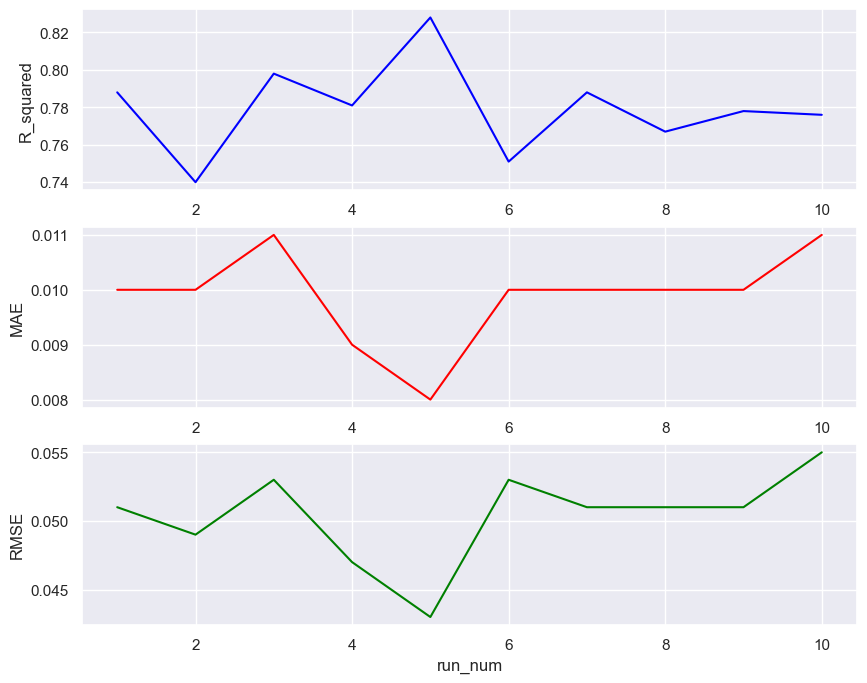

In [29]:
# Visualize results
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

sns.lineplot(data=rf_results_df, x="run_num", y="R_squared", ax=axs[0], color="blue")
sns.lineplot(data=rf_results_df, x="run_num", y="MAE", ax=axs[1], color="red")
sns.lineplot(data=rf_results_df, x="run_num", y="RMSE", ax=axs[2], color="green")
plt.show()

---
#### Feature Selection from Random Forest Runs

* Feature importances were averaged across all 10 runs to reduce randomness and identify consistently impactful variables.
* Top 10 features included a mix of efficiency stats (WS/48, VORP), volume metrics (PTS, FTA, FG), and defensive impact (DWS).
* These features were selected based on their average contribution to predicting points_share and saved for modeling in the next step.

In [30]:
important_features

,run_1,run_2,run_3,run_4,run_5,run_6,run_7,run_8,run_9,run_10
2P,0.013663,0.018499,0.023197,0.014890,0.018300,0.019372,0.013663,0.013350,0.013419,0.015581
2P%,0.004579,0.003839,0.004534,0.002993,0.004458,0.004270,0.004579,0.006302,0.004900,0.002690
2PA,0.006383,0.005819,0.007027,0.007366,0.008348,0.013526,0.006383,0.010328,0.007144,0.006093
3P,0.001745,0.001599,0.002546,0.002307,0.002476,0.002152,0.001745,0.001624,0.002030,0.001853
3P%,0.005979,0.008155,0.006731,0.010717,0.007585,0.012794,0.005979,0.007606,0.011914,0.006561
3PA,0.003336,0.004333,0.002605,0.003318,0.003410,0.004394,0.003336,0.003919,0.003849,0.003683
3PAr,0.003194,0.003118,0.002568,0.003606,0.003483,0.003847,0.003194,0.001996,0.003730,0.002389
AST,0.005821,0.006709,0.006715,0.004982,0.005125,0.005309,0.005821,0.006652,0.005115,0.006083
AST%,0.004345,0.004123,0.009354,0.006240,0.004146,0.004391,0.004345,0.003546,0.005023,0.004170
BLK,0.003415,0.002320,0.003416,0.002221,0.001779,0.002881,0.003415,0.003015,0.002870,0.002494


In [31]:
# Average importance for each feature
avg_importance = important_features.mean(axis=1).sort_values(ascending=False)

In [32]:
# Top N features
n_features = 10 
top_features = avg_importance.head(n_features)
top_features = pd.DataFrame(top_features).rename(columns={0 : "Average Importance"})
top_features

,Average Importance
VORP,0.617126
PER,0.080076
FG,0.020727
DWS,0.018350
WS,0.017173
2P,0.016394
USG%,0.016198
WS/48,0.014433
PTS,0.012628
FTA,0.011198


In [33]:
# Top features columns
top_features.index.to_list()

['VORP', 'PER', 'FG', 'DWS', 'WS', '2P', 'USG%', 'WS/48', 'PTS', 'FTA']

In [34]:
# Export only rows for modeling
data[['points_share', 'VORP', 'PER', 'FG', '2P', 'DWS', 'USG%', 'WS/48', 'WS', 'PTS', 'FTA']]\
.to_csv("data_for_modeling.csv", index=False)